In [1]:
pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 3.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
#Para usarlas es necesario instalar e importar las librerias networkx, numpy y nilearn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nilearn import connectome
import pandas as pd
from nilearn.input_data import NiftiLabelsMasker
from nilearn import connectome
from nilearn.input_data import NiftiLabelsMasker
import nilearn
import numpy as np

def conectividad_mutual_entropy(timeseries):
  l = timeseries
  trans = list(map(list, zip(*l)))
  # creemos la matriz de correlaciones con nilearn
  from nilearn import connectome
  #creamos la función para correlación
  correlation_measure = connectome.ConnectivityMeasure(kind='correlation')

  #creamos las matrices usando la función
  trans = np.array(trans) #hagamos un array de la lista donde estan las series de tiempo transpuestas
  simulation_matrix = correlation_measure.fit_transform([trans])
  simulation_matrix = simulation_matrix[0]

  #hagamos la diagonal 0
  for i in range(0,len(simulation_matrix)):
    simulation_matrix[i][i] = 0
  return simulation_matrix

def metropolis_hastings(M, iteraciones, reinicios, T, acople, resistencia, high = 1.0, low = -1.0):

  graf = nx.convert_matrix.from_numpy_array(M, parallel_edges=False, create_using = nx.DiGraph())
  graf.remove_edges_from(nx.selfloop_edges(graf))

  # Array en el que se depositan las series de tiempo de los nodos
  time_series = np.zeros((len(graf.nodes()), reinicios*iteraciones))
  # Array en el que se depositan las energias asociadas a cada estado de la red en cada iteracion
  E = np.zeros(reinicios*iteraciones)

  # Un vector donde se seleccionan aleatoriamente los nodos a los que se les cambiara su estado
  n = np.random.choice(graf.nodes(), size = reinicios*iteraciones)
  # Vector de numeros aleatorios para 
  number = np.random.rand(reinicios*iteraciones)
  
  for i in graf.nodes():
    graf.nodes[i]['state'] = high if np.random.rand() < 0.5 else low

  for reinicio in range(reinicios):
  
    # Se crea un valor de spin para cada nodo aleatoriamente (condiciones iniciales)
    for i in graf.nodes():
        #graf.nodes[i]['state'] = high if np.random.rand() < 0.5 else low
        graf.nodes[i]['state'] = high if graf.nodes[i]['state'] == low else low

    energia = 0.0
    for nodes in graf.nodes():
      energia_nodo = graf.nodes[nodes]['state']*(resistencia[nodes]/2.0) -(acople/2.0)*graf.nodes[nodes]['state']*np.sum(graf.nodes[vecinos]['state']*M[nodes,vecinos] for vecinos in graf.predecessors(nodes))
      energia += energia_nodo

    for i in range(iteraciones):

      estado_previo = graf.nodes[n[reinicio*iteraciones + i]]['state']

      graf.nodes[n[reinicio*iteraciones + i]]['state'] = high if estado_previo == low else low 

      energia_cambio = 0.0
      for nodes in graf.nodes():
        energia_nodo = graf.nodes[nodes]['state']*(resistencia[nodes]/2.0) -(acople/2.0)*graf.nodes[nodes]['state']*np.sum(graf.nodes[vecinos]['state']*M[nodes,vecinos] for vecinos in graf.predecessors(nodes))
        energia_cambio += energia_nodo

      de = energia_cambio - energia

      if de < 0:
        energia = energia_cambio
      else:
        p = np.exp(-de/T)
        if number[reinicio*iteraciones + i] < p:
          energia = energia_cambio
        else:
          graf.nodes[n[reinicio*iteraciones + i]]['state'] = estado_previo

      E[reinicio*iteraciones + i] = energia

      for k in graf.nodes():
        time_series[k, reinicio*iteraciones + i] = graf.nodes[k]["state"]

  return E, time_series

def calculo_entropia(energias,particiones):
  rango = max(energias) - min(energias)
  ancho_intervalo = rango/particiones
  punto_inicio = min(energias)
  frecuencias = []
  for i in range(particiones):
    y = 0 
    for x in energias:    
      a = punto_inicio + (i*ancho_intervalo)
      b= punto_inicio +  (i+1)*ancho_intervalo
      if i == particiones:
        if x >=  a and x<= b:
          y +=1
      if i != particiones:
        if x >=  a and x< b:
          y +=1
    frecuencias.append(y)
    
  suma_entropia = 0
  for i in frecuencias:
    probabilidad = i/len(energias)
    if probabilidad != 0:
      suma_entropia -= probabilidad*np.log(probabilidad)
  return suma_entropia

/usr/local/lib/python3.7/dist-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [3]:
#%% Conectar con google drive, donde se encuentran los datos HCP1200 requeridos
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [4]:
cd /gdrive/Shareddrives/GENSyR /CNF (Complejidad y NeuroFísica)/Carpeta de trabajo/Tesis Juan y Diego /Datos Poblaciones/Sujetos Tesis

/gdrive/Shareddrives/GENSyR /CNF (Complejidad y NeuroFísica)/Carpeta de trabajo/Tesis Juan y Diego /Datos Poblaciones/Sujetos Tesis


In [5]:
sujetos = ['Social_M+']
estructurales = []
for sujeto in sujetos:
  estructural = np.load(sujeto+ '/EST_sum_no_norm_' + sujeto + '.npy')
  estructural = estructural/np.max(estructural)
  estructural = estructural*(estructural > 0.0*np.max(estructural))
  estructurales.append(estructural)


In [6]:
#Acá se va a hallar el parámetro de temperatura que nos maximiza la entropía
entropias = []
energias = []
temperaturas = []
SIMS = []

for matriz in estructurales:
  M = matriz
  resistencias = np.ones(M.shape[0])
  Temperatura1 = 3.5
  Temperatura2 = 4.5

  E1, time_series1 = metropolis_hastings(M, iteraciones = 500, reinicios = 1100, T = Temperatura1, acople = 1.0, resistencia = resistencias, high = 1.0, low = -1)

  E2, time_series2 = metropolis_hastings(M, iteraciones = 500, reinicios = 1100, T = Temperatura2, acople = 1.0, resistencia = resistencias, high = 1.0, low = -1)

  for i in range(8):
    entropia1 = calculo_entropia(E1,100)
    entropia2 = calculo_entropia(E2,100)

    if entropia1 < entropia2:
      Temperatura1 = (Temperatura1 + Temperatura2)/2
      E1, time_series1 = metropolis_hastings(M, iteraciones = 500, reinicios = 1100, T = Temperatura1, acople = 1.0, resistencia = resistencias, high = 1.0, low = -1)

    else:
      Temperatura2 = (Temperatura1+Temperatura2)/2
      E2, time_series2 = metropolis_hastings(M, iteraciones = 500, reinicios = 1100, T = Temperatura2, acople = 1.0, resistencia = resistencias, high = 1.0, low = -1)

    time_series1 = time_series1[:,30000:len(time_series2[4])]
    SIM = conectividad_mutual_entropy(time_series1)
    SIMS.append(SIM)
    entropias.append(entropia1)
    entropias.append(entropia2)
    energias.append(E1)
    temperaturas.append(Temperatura1)
    temperaturas.append(Temperatura2)

temperaturas = np.array(temperaturas)
SIMS = np.array(SIMS)
energias = np.array(energias)
entropias = np.array(entropias)

np.save(sujetos[0] + '/temperaturas_PE_' + sujetos[0] + '.npy',temperaturas)
np.save(sujetos[0] + '/SIM_PE_' + sujetos[0] + '.npy',SIMS)
np.save(sujetos[0] + '/entropia_' + sujetos[0] +'_.npy',entropias)
np.save(sujetos[0] +'/energias_' + sujetos[0] +'_.npy',energias)
temp = np.array([Temperatura1,Temperatura2])
np.save(sujetos[0] +'/temperaturas_' + sujetos[0] + '_.npy',temp)

  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

In [9]:
rest = np.load(sujetos[0] + '/REST1_PE_' + sujetos[0] + '.npy')
wm = np.load(sujetos[0] + '/WM_PE_' + sujetos[0] + '.npy')
social = np.load(sujetos[0] + '/SOCIAL_PE_' + sujetos[0] + '.npy')
emocion = np.load(sujetos[0] + '/EMOTION_PE_' + sujetos[0] + '.npy')

print('SIMULADO')
print('rest',np.linalg.norm(SIM - rest))
print('wm',np.linalg.norm(wm - SIM))
print('social', np.linalg.norm(social - SIM) )
print('emocion',np.linalg.norm(emocion - SIM))

print('ESTRUCTURAL')
print('rest',np.linalg.norm(estructurales[0] - rest))
print('wm',np.linalg.norm(wm - estructurales[0]))
print('social',np.linalg.norm(social - estructurales[0]))
print('emocion',np.linalg.norm(emocion - estructurales[0]))

print(temp)
print(entropias)

SIMULADO
rest 42.74619707697804
wm 41.61944781281141
social 40.37274090942079
emocion 51.94248592092556
ESTRUCTURAL
rest 43.258287161673564
wm 42.08174310153002
social 40.83102082990603
emocion 52.48495334952043
[3.0234375 3.03125  ]
[3.98364668 3.98364668 3.98364668 3.98364668 3.98364668 3.98364668
 3.98364668 3.89455474]


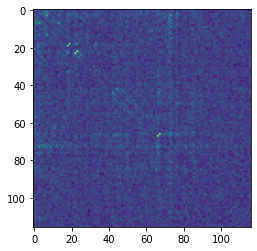

In [16]:
plt.imshow(SIMS[4])

In [11]:
print(entropias)

[3.98364668 3.98364668 3.98364668 3.98364668 3.98364668 3.98364668
 3.98364668 3.89455474]
